## Read CSV Files

In [3]:
import pandas as pd
from collections import namedtuple

def toint(x):
    return int(x);

def tofloat(x):
    return float(x);

## read crystal- and dco- timestamped data
columns = ['Timestamp', 'X', 'Y', 'Z'];

# Store data into named tuple
LimbData = namedtuple("LimbData", "Crystal");
converter = {'Timestamp':toint,'X':tofloat, 'Y':tofloat, 'Z':tofloat}
# Get left pocket (LP) data
crystal_df_rp = pd.read_csv('Data/ACC_COM10.csv', names=columns, index_col=False, converters=converter);
crystal_rp = crystal_df_rp.as_matrix();

RP = LimbData(crystal_rp);

# Get right pocket (RP) data
crystal_df_lp = pd.read_csv('Data/ACC_COM7.csv', names=columns, index_col=False, converters=converter);
crystal_lp = crystal_df_lp.as_matrix();

LP = LimbData(crystal_lp);

## Filters


In [4]:
from scipy import signal
# Quick define a high pass filter
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y


## Plt Data

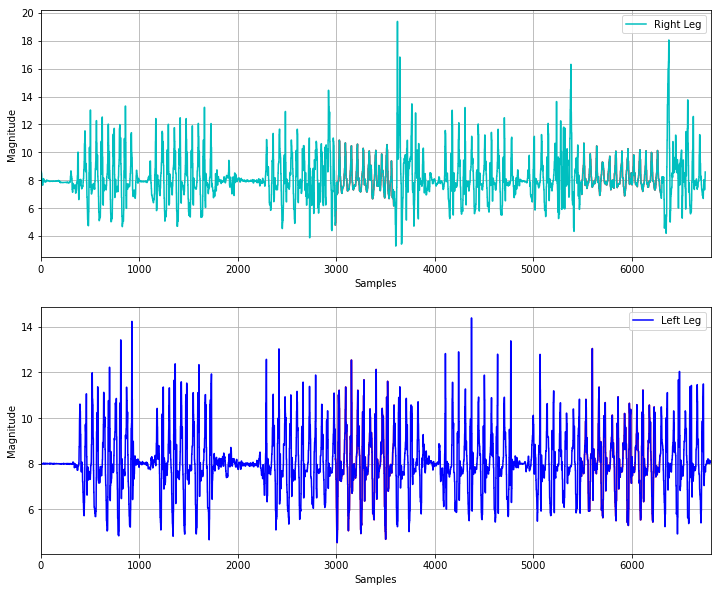

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interp
import mpld3
mpld3.enable_notebook();

# Set default plot size
matplotlib.rcParams['figure.figsize'] = (12.0, 10.0)

freq = 100
cutoff = 10

# Get magnitude of LP and RP
RPMag = np.square(RP.Crystal[:,1]) + np.square(RP.Crystal[:,2]) + np.square(RP.Crystal[:,3]);
RPMag = np.sqrt(RPMag);
#RPMag = abs(butter_highpass_filter(RPMag, cutoff, freq));
rollby = 190;
RPMag = np.roll(RPMag, rollby);

LPMag = np.square(LP.Crystal[:,1]) + np.square(LP.Crystal[:,2]) + np.square(LP.Crystal[:,3]);
LPMag = np.sqrt(LPMag);
#LPMag = abs(butter_highpass_filter(LPMag, cutoff, freq));

fig, (ax1, ax2) = plt.subplots(nrows=2);
frame = plt.gca()


A1 = [2800, 3400];
A2 = [5300, 6100];
ax1.plot(range(rollby+A1[0],rollby+A1[1],1), RPMag[rollby+A1[0]:rollby+A1[1]], 'r');
ax1.plot(range(rollby+A2[0],rollby+A2[1],1), RPMag[rollby+A2[0]:rollby+A2[1]], 'r');
ax1.set_xlim([0,6800])
ax1.plot(RPMag, 'c', label="Right Leg");

ax1.legend();
ax1.set_xlabel("Samples")
ax1.set_ylabel("Magnitude");
ax1.grid();

ax2.plot(range(rollby+A1[0],rollby+A1[1],1), LPMag[rollby+A1[0]:rollby+A1[1]], 'r');
ax2.plot(range(rollby+A2[0],rollby+A2[1],1), LPMag[rollby+A2[0]:rollby+A2[1]], 'r');
ax2.plot(LPMag, 'b', label="Left Leg");
ax2.set_xlim([0,6800])
ax2.legend();
ax2.set_xlabel("Samples")
ax2.set_ylabel("Magnitude");
ax2.grid();
plt.show();

## Check out some cross correlations

A1 ED:  0.137678200439
A2 ED:  0.153972533034
A3 ED:  0.215002042219
A4 ED:  0.157370276934
A5 ED:  0.239399058201


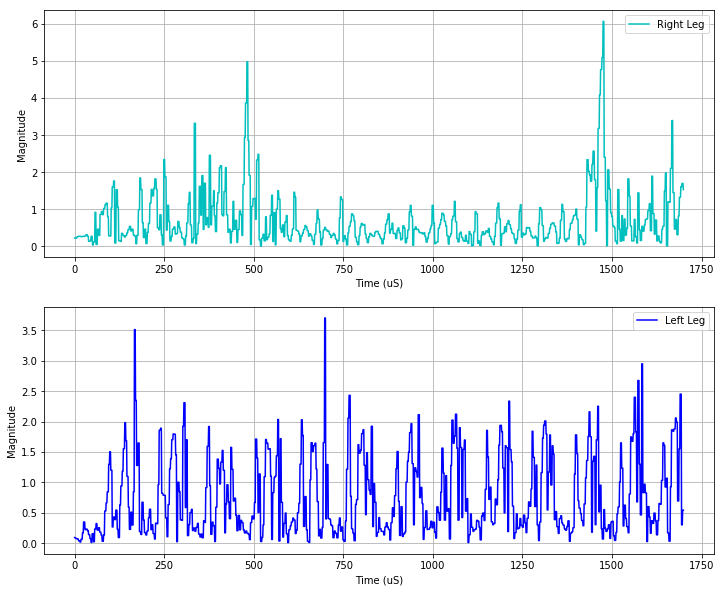

In [7]:
from scipy.signal import correlate
from scipy.interpolate import interp1d
import scipy.spatial.distance as ssd
from dtw import dtw
import math

def activity_integrity(ac1, ac2, window_size, dampener):
    ac_range = max(len(ac1), len(ac2));
    amplifier = min(total_energy(ac1), total_energy(ac2))
    rcs = [];
    div = 1;
    # delta time array to match xcorr
    for i in range(0, ac_range-window_size, window_size):
        #xcorr = correlation(ac1[i:i+window_size],ac2[i:i+window_size]);
        #rcs.append(math.pow((xcorr/amplifier),(1 / dampener)));
        #rcs.append(xcorr);
        ED = abs(total_energy(ac1[i:i+window_size])-total_energy(ac2[i:i+window_size]))/amplifier;
        rcs.append(ED);
    return np.mean(rcs)

def getDTWDist(x, y):
    dist, cost, acc, path = dtw(x, y, dist=lambda x, y: np.linalg.norm(x - y, ord=2));
    return dist;

def correlation(ac1, ac2):
    ac1x = np.arange(0, len(ac1));
    ac2x = np.arange(0, len(ac2));
    
    f = interp1d(ac1x, ac1)
    f2 = interp1d(ac2x, ac2)
    
    points = max(len(ac1), len(ac2));

    xnew = np.linspace ( min(ac1), max(ac1), num = points) 
    xnew2 = np.linspace ( min(ac2), max(ac2), num = points)
    
    ynew = f(xnew) 
    ynew2 = f2(xnew2) 
    
    return ssd.correlation(ynew, ynew2)

def total_energy(sig):
    F = np.fft.fft(sig);
    return np.sum(F*np.conj(F));

A1 = [200, 1000];
A2 = [1000, 1800];
A3 = [2200, 4000];
A4 = [4000, 4800];
A5 = [4900, 6600];

activityRP = RPMag[A1[0]:A1[1]];
activityLP = LPMag[A1[0]:A1[1]];

# Compute cross correlation between every two events found
# NOTE: The number of events on node i and node j MUST be the same

ac1mag = activityRP;
ac2mag = activityLP;

# regularize datasets by subtracting mean and dividing by s.d.
ac1mag -= activityRP.mean(); ac1mag /= activityRP.std();
ac2mag -= activityLP.mean(); ac2mag /= activityLP.std();

#print(correlation(ac1mag, ac2mag))
print("A1 ED: ", getDTWDist(ac1mag.reshape(-1,1), ac2mag.reshape(-1,1)));

activityRP = RPMag[A2[0]:A2[1]];
activityLP = LPMag[A2[0]:A2[1]];

# Compute cross correlation between every two events found
# NOTE: The number of events on node i and node j MUST be the same

ac1mag = activityRP;
ac2mag = activityLP;

# regularize datasets by subtracting mean and dividing by s.d.
ac1mag -= activityRP.mean(); ac1mag /= activityRP.std();
ac2mag -= activityLP.mean(); ac2mag /= activityLP.std();

#print(correlation(ac1mag, ac2mag))
print("A2 ED: ", getDTWDist(ac1mag.reshape(-1,1), ac2mag.reshape(-1,1)));

activityRP = RPMag[A3[0]:A3[1]];
activityLP = LPMag[A3[0]:A3[1]];

# Compute cross correlation between every two events found
# NOTE: The number of events on node i and node j MUST be the same

ac1mag = activityRP;
ac2mag = activityLP;

# regularize datasets by subtracting mean and dividing by s.d.
ac1mag -= activityRP.mean(); ac1mag /= activityRP.std();
ac2mag -= activityLP.mean(); ac2mag /= activityLP.std();

#print(correlation(ac1mag, ac2mag))
print("A3 ED: ", getDTWDist(ac1mag.reshape(-1,1), ac2mag.reshape(-1,1)));

activityRP = RPMag[A4[0]:A4[1]];
activityLP = LPMag[A4[0]:A4[1]];

# Compute cross correlation between every two events found
# NOTE: The number of events on node i and node j MUST be the same

ac1mag = activityRP;
ac2mag = activityLP;

# regularize datasets by subtracting mean and dividing by s.d.
ac1mag -= activityRP.mean(); ac1mag /= activityRP.std();
ac2mag -= activityLP.mean(); ac2mag /= activityLP.std();

#print(correlation(ac1mag, ac2mag))
print("A4 ED: ", getDTWDist(ac1mag.reshape(-1,1), ac2mag.reshape(-1,1)));

activityRP = RPMag[A5[0]:A5[1]];
activityLP = LPMag[A5[0]:A5[1]];

# Compute cross correlation between every two events found
# NOTE: The number of events on node i and node j MUST be the same

ac1mag = activityRP;
ac2mag = activityLP;

# regularize datasets by subtracting mean and dividing by s.d.
ac1mag -= activityRP.mean(); ac1mag /= activityRP.std();
ac2mag -= activityLP.mean(); ac2mag /= activityLP.std();

#print(correlation(ac1mag, ac2mag))
print("A5 ED: ", getDTWDist(ac1mag.reshape(-1,1), ac2mag.reshape(-1,1)));

#print("Energy 1: ", total_energy(ac1mag));
#print("Energy 2: ", total_energy(ac2mag));
#print("Energy Difference: ", abs(total_energy(ac1mag) - total_energy(ac2mag)));

fig, (ax1, ax2) = plt.subplots(nrows=2);

ax1.plot(abs(ac1mag), 'c', label="Right Leg");
ax1.legend();
#ax1.set_ylim([0, 2])
ax1.set_xlabel("Time (uS)")
ax1.set_ylabel("Magnitude");
ax1.grid();

ax2.plot(abs(ac2mag), 'b', label="Left Leg");
ax2.legend();
#ax2.set_ylim([0, 2])
ax2.set_xlabel("Time (uS)")
ax2.set_ylabel("Magnitude");
ax2.grid();
plt.show();

# Find X-Correlation of the anharmonic signals
#xcorr = correlate(ac1mag,ac2mag);

# delta time array to match xcorr
#t = np.asarray(time1);
#dt = np.linspace(-t[-1], t[-1], 2*nsamples-1)
#recovered_sample_shift = dt[xcorr.argmax()]

#dt = np.arange(1-nsamples, nsamples);
#recovered_sample_shift = dt[xcorr.argmax()];
#offset = abs(recovered_sample_shift * SRATE);

#print ("Recovered offset: ", recovered_sample_shift, " samples, or " , offset, " microseconds for 100Hz sample rate");
